In [2]:
#1024——glitch生成
import matplotlib.pyplot as pp
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform,get_fd_waveform
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import sigma
from pycbc import types
from pycbc.detector import Detector
from pycbc.filter import matched_filter
import pycbc
from pycbc.psd import welch
import pycbc.noise
import pycbc.psd
from pycbc import waveform
import scipy
import h5py
import os
import random
import numpy as np

from multiprocessing import Pool
from pycbc import distributions

from scipy.interpolate import interp1d
from gwpy.timeseries import TimeSeries

In [3]:
1

1

In [4]:
import numpy as np
from scipy.integrate import quad
#函数定义
def z_to_d_ang(z, H0, Omega_m, Omega_Lambda):#输入红移输出直径距离
    c = 299792.458  # 光速，单位：km/s
    # 定义被积函数
    integrand = lambda z: 1 / np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)
    # 积分计算
    result, _ = quad(integrand, 0, z)
    # 计算距离
    distance = c / (H0 * (1+z) )* result
    return distance


def zl_zs_to_dsl_ang(zl,zs, H0, Omega_m, Omega_Lambda):#输入红移、输出直径距离
    c = 299792.458  # 光速，单位：km/s
    integrand = lambda z: 1 / np.sqrt(Omega_m * (1 + z)**3 + Omega_Lambda)
    result, _ = quad(integrand, zl, zs)
    distance = c / (H0 * (1+zs) )* result
    return distance


def d_ang_to_dl(D_ang,z):#输入角直径距离、输出光度距离
    return D_ang*(1+z)**2


In [5]:
import numpy as np
#点质量透镜模型
class Point_mass_lens_model:
    def __init__(self):
        pass
    
    def F_f(self, f, M_LZ, epsilon, D_L, xi_0, D_s):
        return np.abs(self.miu_p(self.y(epsilon, D_L, xi_0, D_s), self.beta(self.y(epsilon, D_L, xi_0, D_s))))**0.5 - \
            1j * np.abs(self.miu_c(self.y(epsilon, D_L, xi_0, D_s), self.beta(self.y(epsilon, D_L, xi_0, D_s))))**0.5 * \
            np.exp(2j * np.pi * f * self.dt(M_LZ, self.y(epsilon, D_L, xi_0, D_s), self.beta(self.y(epsilon, D_L, xi_0, D_s))))
    
    def miu_p(self, y, beta):
        return 0.5 + (y**2 + 2) / (2 * y * beta)
    
    def miu_c(self, y, beta):
        return 0.5 - (y**2 + 2) / (2 * y * beta)
    #G:m³/kg·s²
    def dt(self, M_LZ, y, beta):#单位s
        return 4 * M_LZ*(y * beta / 2 + np.log((beta + y) / (beta - y))) * scipy.constants.G / scipy.constants.c**3 *(1.989e30)
    
    def beta(self, y):
        return (y**2 + 4)**0.5
    
    def y(self, epsilon, D_L, xi_0, D_s):
        return epsilon * D_L / xi_0 / D_s


    
    
def yy_ll(epsilon, D_L, xi_0, D_s):
    return epsilon * D_L / xi_0 / D_s
    
def miu_p_sis(y_l):
    return 1+1/y_l

def miu_c_sis(y_l):
    return -1+1/y_l
    
def det_t_sis(M_L,y_l,zl):
    return 8*M_L*(1+zl)*y_l* scipy.constants.G / scipy.constants.c**3 *(1.989e30)
    
    
def miu_p_pm(y_l):
    return 1/2+(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)

def miu_c_pm(y_l):
    return 1/2-(y_l**2+2)/(2*y_l*(y_l**2+4)**0.5)
    
def det_t_pm(M_L,y_l,zl):
    return 2*M_L*(1+zl)*(y_l*(y_l**2+4)**0.5+2*np.log(((y_l**2+4)**0.5+y_l)/((y_l**2+4)**0.5-y_l)))* scipy.constants.G / scipy.constants.c**3 *(1.989e30)
    
    
def PM_model(f, miu_p, miu_c, det_t):
    return np.abs(miu_p)**0.5 - 1j * np.abs(miu_c)**0.5 *  np.exp(2j * np.pi * f * det_t)

def SIS_model(f, miu_p, miu_c, det_t,y_l):
    if y_l<1:
        return np.abs(miu_p)**0.5 - 1j * np.abs(miu_c)**0.5 *  np.exp(2j * np.pi * f * det_t)
    else:
        return np.abs(miu_p)**0.5 
    
def y_lens(epsilon, D_L, xi_0, D_s):
    return epsilon * D_L / xi_0 / D_s
    
def M_L_Z(M_L,z):
    return M_L*(1+z)
    
def x_i_0(M_L,D_LS,D_L,D_S): #G:m³/kg·s² #m^1 kg^-1 Mc^1  Mpc^1 单位转化成MPc,,,,1.989×1030 千克,,,3.0857E+22
    return ((4*scipy.constants.G*M_L/scipy.constants.c**2)*(D_LS*D_L/D_S) /(3.0857e22)*(1.989e30))**0.5

def mc_q_to_m1_m2(mc,q):
    m1=(mc**5*(1+q)/q**3)**(1/5)
    m2=m1*q
    return m1,m2


def get_snr(data,T_obs,fs,psd):
    #波形、1、频率、psd
    N = T_obs*fs
    delta_f = 1.0/T_obs
    delta_t = 1.0/fs

#     win = tukey(N,alpha=1.0/8.0)
    idx = np.argwhere(psd==0.0)
    psd[idx] = 1e300    

    xf = np.fft.rfft(data)*delta_t
    #fig = plt.figure()
    #plt.plot(np.real(xf))
    #plt.plot(np.imag(xf))
    SNRsq = 4.0*np.sum((np.abs(xf)**2)/psd)*delta_f
    return np.sqrt(SNRsq)

@np.vectorize
def gw_waveform(f,A,D,m1,m2,t_c,psi_c,z):
    M=m1+m2
    qq=m1*m2/M**2
    Mz=(1+z)*M
    Mc=qq**(3/5)*Mz
    f_cut=1/(6**(3/2)*np.pi*Mz) / scipy.constants.G * scipy.constants.c**3 /(1.989e30)
    def fi(f,t_c,psi_c,qq,Mc):
        return 2*np.pi*f*t_c-psi_c-np.pi/4+3/4*(8*np.pi*Mc*f)**(-5/3)*(1+20/9*(743/336+11/4*qq)*(np.pi*Mz*f)**(2/3)-16*np.pi*(np.pi*Mz*f))
    if f_cut<f:
        return 0
    else:
        return A/D*Mc**(5/6)*f**(-7/6)*np.exp(1j*fi(f,t_c,psi_c,qq,Mc))*1e-19/0.27
    
    
def I_to_y_sis(y_l,I):
    return I-miu_c_sis(y_l)/miu_p_sis(y_l)

def I_to_y_pm(y_l,I):
    return I+miu_c_pm(y_l)/miu_p_pm(y_l)

In [6]:
#固定的参数
calculator = Point_mass_lens_model()
T_obs=10
N_fs=4096#采样率为4096Hz
N_s=T_obs*N_fs#对应时域为10s

flen = round(N_s/2)+1
delta_f = 1.0 / T_obs
delta_t=1/N_fs
f_low=30
flow=30

tsamples = int(T_obs / delta_t)




# 打开txt文件以读取内容
with open('/home/suntianyang/work5/ligo/aligo_O4high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdh = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdh.sample_frequencies)  # 生成的 y 值
y_new[psdh.sample_frequencies<f_low]=0
psdh.data=y_new
psdh_snr = psdh.copy()

# 打开txt文件以读取内容
with open('/home/suntianyang/work5/ligo/aligo_O4high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdl = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdl.sample_frequencies)  # 生成的 y 值
y_new[psdl.sample_frequencies<f_low]=0
psdl.data=y_new
psdl_snr = psdl.copy()

# 打开txt文件以读取内容
with open('/home/suntianyang/work5/ligo/avirgo_O4high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdv = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdv.sample_frequencies)  # 生成的 y 值
y_new[psdv.sample_frequencies<f_low]=0
psdv.data=y_new
psdv_snr = psdv.copy()

# 打开txt文件以读取内容
with open('/home/suntianyang/work5/ligo/k1_o4_high.txt', 'r') as file:
    lines = file.readlines()


# 解析数据
data_lines = [line.strip().split() for line in lines]

data = [[float(value) for value in line] for line in data_lines]

list_los = []  # 用于存储第一列数据
list_losvail = []  # 用于存储第二列数据
# 遍历数据并将其添加到相应的列表中
for row in data:
    list_los.append(row[0])  # 将第一列数据添加到list_los
    list_losvail.append(row[1]**2)  # 将第二列数据添加到list_losvail
    
    
psdk = pycbc.psd.aLIGO140MpcT1800545(flen, delta_f, flow)
interp_function = interp1d(list_los, list_losvail, kind='linear')
y_new = interp_function(psdk.sample_frequencies)  # 生成的 y 值
y_new[psdk.sample_frequencies<f_low]=0
psdk.data=y_new
psdk_snr = psdk.copy()


In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as nn_utils
import zuko
from torch.optim import lr_scheduler


from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner, mark_point
from lampe.utils import GDStep
from lampe.data import H5Dataset
from lampe.diagnostics import expected_coverage_mc

import h5py
import numpy as np

from datetime import datetime

# PM_ROC(包含数据集)

In [8]:
#固定的参数
calculator = Point_mass_lens_model()
det_1 = Detector('L1')
det_2 = Detector('H1')
det_3 = Detector('V1')
det_4 = Detector('K1')




for SSSEEERRRNNN in [12]:
    def get_wave_plus_gaosnoise_t_gen(saaaa):
        hp_flens=types.FrequencySeries(np.zeros(round(N_s/2)+1),delta_f=1.0 / T_obs)#采样定律
        while True:
            epsilon=random.uniform(1e-6,0.5)*1e-6#MPc

            #dl_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(10,6000))#MPc
            #dl_samples=dl_distribution.rvs(size=1)
            #D_L=dl_samples[0][0]
            #dl_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(D_L,6000+D_L))#MPc
            #dl_samples=dl_distribution.rvs(size=1)
            #D_LS=dl_samples[0][0]-D_L#MPc

            M_L=random.uniform(1e3,1e5)#M


            zl_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(0,1.0))#MPc
            zl_samples=zl_distribution.rvs(size=1)
            Z_L=zl_samples[0][0]

            zs_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(Z_L,1.0))#MPc
            zs_samples=zs_distribution.rvs(size=1)
            Z_s=zs_samples[0][0]

            D_S=z_to_d_ang(Z_s,70,0.3,0.7)
            D_LS=zl_zs_to_dsl_ang(Z_L,Z_s,70,0.3,0.7)
            D_L=z_to_d_ang(Z_L,70,0.3,0.7)

            #z_to_DL
            M_LZ=M_L_Z(M_L,Z_L)#M
            xi_0=x_i_0(M_L,D_LS,D_L,D_S)
            y_l=yy_ll(epsilon, D_L, xi_0, D_S)

            #print(calculator.dt(M_LZ, calculator.y(epsilon, D_L, xi_0, D_S), calculator.beta(calculator.y(epsilon, D_L, xi_0, D_S))))
            #print(calculator.miu_p(calculator.y(epsilon, D_L, xi_0, D_S), calculator.beta(calculator.y(epsilon, D_L, xi_0, D_S))))
            #print(calculator.miu_c(calculator.y(epsilon, D_L, xi_0, D_S), calculator.beta(calculator.y(epsilon, D_L, xi_0, D_S))))

            dtt=det_t_pm(M_L,y_l,Z_L)
            miu_pp=miu_p_pm(y_l)
            miu_cc=miu_c_pm(y_l)

            I_tt=np.abs(miu_cc)/np.abs(miu_pp)
            #if dtt<2.25e-3 or dtt>3.52 or miu_pp<1.7 or miu_pp>10.51 or miu_cc<-9.51 or miu_cc>-0.17:
            #    continue
            if dtt>0.2 or I_tt<0 or I_tt>1:
                continue

            #print(dtt,miu_pp,miu_cc)
            result = types.FrequencySeries(PM_model(hp_flens.sample_frequencies.data,miu_pp, miu_cc, dtt),delta_f=N_fs/N_s)

            asdasd=np.random.rand()
            if asdasd<saaaa:#%10
                saaaa_1=0.0
                result=1
                dtt=0.0
                I_tt=0.0
            else:
                saaaa_1=1.0
            tc=random.uniform(7,8)
            mc_distribution=distributions.MchirpfromUniformMass1Mass2(mc=(5,80))
            q_distribution=distributions.QfromUniformMass1Mass2(q=(0.5,2.0))#0.5-1
            mc_samples = mc_distribution.rvs(size=1)
            q_samples = q_distribution.rvs(size=1)
            mc=mc_samples[0][0]
            q=q_samples[0][0]
            m1,m2=mc_q_to_m1_m2(mc,q)

            distance=d_ang_to_dl(D_S,Z_s)

            sky_distribution = distributions.sky_location.UniformSky()
            sky_samples=sky_distribution.rvs(size=1)
            dec = sky_samples[0][0]#纬度
            ra = sky_samples[0][1]#经度

            psi = random.uniform(0,np.pi*2)#偏振角ψ
            inc=np.arccos(-1.0 + 2.0*np.random.rand())#倾角
            coa_phase=random.uniform(0,np.pi*2)#合并相位
            #IMRPhenomPv2，SEOBNRv4_opt,IMRPhenomTPHM



            try:
                hp, hc = get_td_waveform(approximant='IMRPhenomTPHM',
                                         mass1=m1*(1+Z_s),#红移质量1
                                         mass2=m2*(1+Z_s),#红移质量2
                                         distance=distance,#距离，MPC
                                         coa_phase=coa_phase,#合并相位
                                         inclination=inc,#轨道和视线的夹角
                                         spin1x=0,
                                         spin1y=0,
                                         spin1z=0,#自旋1
                                         spin2x=0,
                                         spin2y=0,
                                         spin2z=0,#自旋2
                                         eccentricity=0,#轨道偏心率
                                         lambda1=0,#潮汐相，中子星有
                                         lambda2=0,
                                         delta_t=1.0/N_fs,
                                         f_lower=30)
            except:
                continue

            fp_1, fc_1 = det_1.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
            fp_2, fc_2 = det_2.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
            fp_3, fc_3 = det_3.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
            fp_4, fc_4 = det_4.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)

            ht_1 = fp_1*hp + fc_1*hc
            ht_2 = fp_2*hp + fc_2*hc
            ht_3 = fp_3*hp + fc_3*hc
            ht_4 = fp_4*hp + fc_4*hc


            ht_1.resize(N_s)
            ht_1=ht_1.cyclic_time_shift(ht_1.start_time+tc)
            ht_1.start_time=0
            ht_2.resize(N_s)
            ht_2=ht_2.cyclic_time_shift(ht_2.start_time+tc)
            ht_2.start_time=0
            ht_3.resize(N_s)
            ht_3=ht_3.cyclic_time_shift(ht_3.start_time+tc)
            ht_3.start_time=0
            ht_4.resize(N_s)
            ht_4=ht_4.cyclic_time_shift(ht_4.start_time+tc)
            ht_4.start_time=0

            hp_f_1=ht_1.to_frequencyseries()
            hp_flens_1=hp_f_1*result
            hp_t_lens_1=hp_flens_1.to_timeseries()
            #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
            hp_f_2=ht_2.to_frequencyseries()
            hp_flens_2=hp_f_2*result
            hp_t_lens_2=hp_flens_2.to_timeseries()
            #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
            hp_f_3=ht_3.to_frequencyseries()
            hp_flens_3=hp_f_3*result
            hp_t_lens_3=hp_flens_3.to_timeseries()
            #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
            hp_f_4=ht_4.to_frequencyseries()
            hp_flens_4=hp_f_4*result
            hp_t_lens_4=hp_flens_4.to_timeseries()


            #利用高斯 psd生成噪声：
            noise_et1 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdl)
            #添加非高斯噪声后要用welch方法估计psd——假设没有方法能合理的估计psd（psd中包含各种非高斯的干扰）
            hp_t_lens_plusnoise_1=hp_t_lens_1.copy()
            hp_t_lens_plusnoise_1.data+=noise_et1.data

            noise_et2 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdh)
            hp_t_lens_plusnoise_2=hp_t_lens_2.copy()
            hp_t_lens_plusnoise_2.data+=noise_et2.data

            noise_et3 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdv)
            hp_t_lens_plusnoise_3=hp_t_lens_3.copy()
            hp_t_lens_plusnoise_3.data+=noise_et3.data

            noise_et4 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdk)
            hp_t_lens_plusnoise_4=hp_t_lens_4.copy()
            hp_t_lens_plusnoise_4.data+=noise_et4.data

            snr1 = get_snr(hp_t_lens_1,T_obs,N_fs,psdl_snr.data)
            snr2 = get_snr(hp_t_lens_2,T_obs,N_fs,psdh_snr.data)
            snr3 = get_snr(hp_t_lens_3,T_obs,N_fs,psdv_snr.data)
            snr4 = get_snr(hp_t_lens_4,T_obs,N_fs,psdk_snr.data)
            snr=(snr1**2+snr2**2+snr3**2+snr4**2)**0.5
            #print(snr)

            #print(snr,D_S,D_LS,D_L,distance)
            if snr<(SSSEEERRRNNN-2) or snr>(SSSEEERRRNNN+2):
                continue

            L11data = (hp_t_lens_plusnoise_1.to_frequencyseries() / psdl_snr**0.5).to_timeseries()#要除以0置成正无穷的
            H11data = (hp_t_lens_plusnoise_2.to_frequencyseries() / psdh_snr**0.5).to_timeseries()#要除以0置成正无穷的
            V11data = (hp_t_lens_plusnoise_3.to_frequencyseries() / psdv_snr**0.5).to_timeseries()#要除以0置成正无穷的
            K11data = (hp_t_lens_plusnoise_4.to_frequencyseries() / psdk_snr**0.5).to_timeseries()#要除以0置成正无穷的

            canshu=[dtt,I_tt]#12个

            return [L11data.data,H11data.data,V11data.data,K11data.data],[saaaa_1]


        

    pool = Pool(processes=56)#16,24,32
    results = pool.map(get_wave_plus_gaosnoise_t_gen, [0.5]*20000)
    all_x_vail_data = torch.tensor(np.concatenate([x for x,y in results]).reshape(20000,4,40960),dtype=torch.float32)
    all_y_vail = torch.tensor(np.concatenate([y for x,y in results]).reshape(20000,1),dtype=torch.float32)
    pool.close()
    pool.join()
    
    np.save(f'./data/test_data_y_roc_PM_{SSSEEERRRNNN}.npy',all_x_vail_data)
    np.save(f'./data/test_label_roc_PM_{SSSEEERRRNNN}.npy',all_y_vail)

: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]




: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]

WARNING


: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]

: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]
WARNING
WARNINGWARNING

: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]
: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]: IERSStaleWarning: leap-second file is expired. [astropy.utils.iers.iers]WARNING




: IERSStaleWarning: leap-second file is expired. [astro

# SIS_ROC(包含数据集)

In [ ]:
#固定的参数
calculator = Point_mass_lens_model()
det_1 = Detector('L1')
det_2 = Detector('H1')
det_3 = Detector('V1')
det_4 = Detector('K1')



#16,
for SSSEEERRRNNN in [12]:
    def get_wave_plus_gaosnoise_t_gen_sis(saaaa):
        hp_flens=types.FrequencySeries(np.zeros(round(N_s/2)+1),delta_f=1.0 / T_obs)#采样定律
        while True:
            epsilon=random.uniform(1e-6,0.5)*1e-6#MPc

            #dl_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(10,6000))#MPc
            #dl_samples=dl_distribution.rvs(size=1)
            #D_L=dl_samples[0][0]
            #dl_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(D_L,6000+D_L))#MPc
            #dl_samples=dl_distribution.rvs(size=1)
            #D_LS=dl_samples[0][0]-D_L#MPc

            M_L=random.uniform(1e3,1e5)#M


            zl_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(0,1.0))#MPc
            zl_samples=zl_distribution.rvs(size=1)
            Z_L=zl_samples[0][0]

            zs_distribution=distributions.power_law.UniformPowerLaw(dim=3,bound =(Z_L,1.0))#MPc
            zs_samples=zs_distribution.rvs(size=1)
            Z_s=zs_samples[0][0]

            D_S=z_to_d_ang(Z_s,70,0.3,0.7)
            D_LS=zl_zs_to_dsl_ang(Z_L,Z_s,70,0.3,0.7)
            D_L=z_to_d_ang(Z_L,70,0.3,0.7)

            #z_to_DL
            M_LZ=M_L_Z(M_L,Z_L)#M
            xi_0=x_i_0(M_L,D_LS,D_L,D_S)
            y_l=yy_ll(epsilon, D_L, xi_0, D_S)

            #print(calculator.dt(M_LZ, calculator.y(epsilon, D_L, xi_0, D_S), calculator.beta(calculator.y(epsilon, D_L, xi_0, D_S))))
            #print(calculator.miu_p(calculator.y(epsilon, D_L, xi_0, D_S), calculator.beta(calculator.y(epsilon, D_L, xi_0, D_S))))
            #print(calculator.miu_c(calculator.y(epsilon, D_L, xi_0, D_S), calculator.beta(calculator.y(epsilon, D_L, xi_0, D_S))))

            dtt=det_t_sis(M_L,y_l,Z_L)
            miu_pp=miu_p_sis(y_l)
            miu_cc=miu_c_sis(y_l)

            I_tt=np.abs(miu_cc)/np.abs(miu_pp)
            #if dtt<2.25e-3 or dtt>3.52 or miu_pp<1.7 or miu_pp>10.51 or miu_cc<-9.51 or miu_cc>-0.17:
            #    continue
            if dtt>0.2 or I_tt<0 or I_tt>1:
                continue

            #print(dtt,miu_pp,miu_cc)
            try:
                result = types.FrequencySeries(SIS_model(hp_flens.sample_frequencies.data,miu_pp, miu_cc, dtt,y_l),delta_f=N_fs/N_s)
            except:
                continue

            asdasd=np.random.rand()
            if asdasd<saaaa:#%10
                saaaa_1=0.0
                result=1
                dtt=0.0
                I_tt=0.0
            else:
                saaaa_1=1.
            tc=random.uniform(7,8)
            mc_distribution=distributions.MchirpfromUniformMass1Mass2(mc=(5,80))
            q_distribution=distributions.QfromUniformMass1Mass2(q=(0.5,2.0))#0.5-1
            mc_samples = mc_distribution.rvs(size=1)
            q_samples = q_distribution.rvs(size=1)
            mc=mc_samples[0][0]
            q=q_samples[0][0]
            m1,m2=mc_q_to_m1_m2(mc,q)

            distance=d_ang_to_dl(D_S,Z_s)

            sky_distribution = distributions.sky_location.UniformSky()
            sky_samples=sky_distribution.rvs(size=1)
            dec = sky_samples[0][0]#纬度
            ra = sky_samples[0][1]#经度

            psi = random.uniform(0,np.pi*2)#偏振角ψ
            inc=np.arccos(-1.0 + 2.0*np.random.rand())#倾角
            coa_phase=random.uniform(0,np.pi*2)#合并相位
            #IMRPhenomPv2，SEOBNRv4_opt,IMRPhenomTPHM

            try:
                hp, hc = get_td_waveform(approximant='IMRPhenomTPHM',
                                         mass1=m1*(1+Z_s),#红移质量1
                                         mass2=m2*(1+Z_s),#红移质量2
                                         distance=distance,#距离，MPC
                                         coa_phase=coa_phase,#合并相位
                                         inclination=inc,#轨道和视线的夹角
                                         spin1x=0,
                                         spin1y=0,
                                         spin1z=0,#自旋1
                                         spin2x=0,
                                         spin2y=0,
                                         spin2z=0,#自旋2
                                         eccentricity=0,#轨道偏心率
                                         lambda1=0,#潮汐相，中子星有
                                         lambda2=0,
                                         delta_t=1.0/N_fs,
                                         f_lower=30)
            except:
                continue

            fp_1, fc_1 = det_1.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
            fp_2, fc_2 = det_2.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
            fp_3, fc_3 = det_3.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)
            fp_4, fc_4 = det_4.antenna_pattern(
                            right_ascension=ra, declination=dec, polarization=psi, t_gps=tc)

            ht_1 = fp_1*hp + fc_1*hc
            ht_2 = fp_2*hp + fc_2*hc
            ht_3 = fp_3*hp + fc_3*hc
            ht_4 = fp_4*hp + fc_4*hc


            ht_1.resize(N_s)
            ht_1=ht_1.cyclic_time_shift(ht_1.start_time+tc)
            ht_1.start_time=0
            ht_2.resize(N_s)
            ht_2=ht_2.cyclic_time_shift(ht_2.start_time+tc)
            ht_2.start_time=0
            ht_3.resize(N_s)
            ht_3=ht_3.cyclic_time_shift(ht_3.start_time+tc)
            ht_3.start_time=0
            ht_4.resize(N_s)
            ht_4=ht_4.cyclic_time_shift(ht_4.start_time+tc)
            ht_4.start_time=0

            hp_f_1=ht_1.to_frequencyseries()
            hp_flens_1=hp_f_1*result
            hp_t_lens_1=hp_flens_1.to_timeseries()
            #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
            hp_f_2=ht_2.to_frequencyseries()
            hp_flens_2=hp_f_2*result
            hp_t_lens_2=hp_flens_2.to_timeseries()
            #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
            hp_f_3=ht_3.to_frequencyseries()
            hp_flens_3=hp_f_3*result
            hp_t_lens_3=hp_flens_3.to_timeseries()
            #snr1 = get_snr(hp,T_obs,N_fs,psdl_snr.data)
            hp_f_4=ht_4.to_frequencyseries()
            hp_flens_4=hp_f_4*result
            hp_t_lens_4=hp_flens_4.to_timeseries()


            #利用高斯 psd生成噪声：
            noise_et1 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdl)
            #添加非高斯噪声后要用welch方法估计psd——假设没有方法能合理的估计psd（psd中包含各种非高斯的干扰）
            hp_t_lens_plusnoise_1=hp_t_lens_1.copy()
            hp_t_lens_plusnoise_1.data+=noise_et1.data

            noise_et2 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdh)
            hp_t_lens_plusnoise_2=hp_t_lens_2.copy()
            hp_t_lens_plusnoise_2.data+=noise_et2.data

            noise_et3 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdv)
            hp_t_lens_plusnoise_3=hp_t_lens_3.copy()
            hp_t_lens_plusnoise_3.data+=noise_et3.data

            noise_et4 = pycbc.noise.noise_from_psd(tsamples, delta_t, psdk)
            hp_t_lens_plusnoise_4=hp_t_lens_4.copy()
            hp_t_lens_plusnoise_4.data+=noise_et4.data

            snr1 = get_snr(hp_t_lens_1,T_obs,N_fs,psdl_snr.data)
            snr2 = get_snr(hp_t_lens_2,T_obs,N_fs,psdh_snr.data)
            snr3 = get_snr(hp_t_lens_3,T_obs,N_fs,psdv_snr.data)
            snr4 = get_snr(hp_t_lens_4,T_obs,N_fs,psdk_snr.data)
            snr=(snr1**2+snr2**2+snr3**2+snr4**2)**0.5
            #print(snr)

            #print(snr,D_S,D_LS,D_L,distance)
            if snr<(SSSEEERRRNNN-2) or snr>(SSSEEERRRNNN+2):
                continue

            L11data = (hp_t_lens_plusnoise_1.to_frequencyseries() / psdl_snr**0.5).to_timeseries()#要除以0置成正无穷的
            H11data = (hp_t_lens_plusnoise_2.to_frequencyseries() / psdh_snr**0.5).to_timeseries()#要除以0置成正无穷的
            V11data = (hp_t_lens_plusnoise_3.to_frequencyseries() / psdv_snr**0.5).to_timeseries()#要除以0置成正无穷的
            K11data = (hp_t_lens_plusnoise_4.to_frequencyseries() / psdk_snr**0.5).to_timeseries()#要除以0置成正无穷的

            canshu=[dtt,I_tt]#12个

            return [L11data.data,H11data.data,V11data.data,K11data.data],[saaaa_1]


    pool = Pool(processes=56)#16,24,32
    results = pool.map(get_wave_plus_gaosnoise_t_gen_sis, [0.5]*20000)
    all_x_vail_data = torch.tensor(np.concatenate([x for x,y in results]).reshape(20000,4,40960),dtype=torch.float32)
    all_y_vail = torch.tensor(np.concatenate([y for x,y in results]).reshape(20000,1),dtype=torch.float32)
    pool.close()
    pool.join()
    
    np.save(f'./data/test_data_y_roc_SIS_{SSSEEERRRNNN}.npy',all_x_vail_data)
    # ROC的数据集
    np.save(f'./data/test_label_roc_SIS_{SSSEEERRRNNN}.npy',all_y_vail)

WARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNINGWARNING

# 三种网络的加载

## RESNET

In [7]:
def weight_init(m):
    if isinstance(m, (nn.Conv1d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
        nn.init.constant_(m.bias.data, 0.0)

class Bottlrneck(torch.nn.Module):
    def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
        super(Bottlrneck, self).__init__()
        self.stride = 1
        if downsample == True:
            self.stride = 2
        #在这里添加BatchNorm1d和Dropout是最合适的
        self.layer = torch.nn.Sequential(
            torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
            torch.nn.BatchNorm1d(Med_channel),
            torch.nn.ReLU(),
            torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
            torch.nn.BatchNorm1d(Med_channel),
            #torch.nn.ReLU(),
            torch.nn.Conv1d(Med_channel, Out_channel, 1),
            torch.nn.BatchNorm1d(Out_channel),
            #torch.nn.ReLU(),
        )

        if In_channel != Out_channel:
            self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
        else:
            self.res_layer = None

        self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

    def forward(self,x):
        if self.res_layer is not None:
            residual = self.res_layer(x)
        else:
            residual = x
        return self.jia_relu(self.layer(x)+residual)
    
    def forward(self,x):
        if self.res_layer is not None:
            residual = self.res_layer(x)
        else:
            residual = x
        return self.layer(x)+residual

class ResNet(torch.nn.Module):
    def __init__(self,in_channels=1,classes=5):
        super(ResNet, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
            torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

            Bottlrneck(64,64,256,False),
            Bottlrneck(256,64,256,False),
            Bottlrneck(256,64,256,False),#256*x/4*x/4



            Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
            Bottlrneck(512,128,512, False),
            Bottlrneck(512,128,512, False),
            Bottlrneck(512,128,512, False),



            Bottlrneck(512,256,1024, True),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),
            Bottlrneck(1024,256,1024, False),



            Bottlrneck(1024,512,2048, True),
            Bottlrneck(2048,512,2048, False),
            Bottlrneck(2048,512,2048, False),

            torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
        )
        self.classifer = torch.nn.Sequential(
            torch.nn.Linear(2048,classes)#变成每类特征的信息
        )
        

    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,2048)
        x = self.classifer(x)
        return x

model=torch.load(f'/home/suntianyang/work5/ligo/net_ann_2/NPE_mid_t_lens_res_can_all.pth')
model.eval();

In [8]:
#重置网络参数，方便for循环调参
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0.0)

class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Linear(2, 128) 
        self.norm1 = nn.LayerNorm(128)
        
        self.layer2 = nn.Linear(128, 128)
        self.norm2 = nn.LayerNorm(128)

        self.layer3 = nn.Linear(128, 128)
        self.norm3 = nn.LayerNorm(128)
        
        self.layer4 = nn.Linear(128, 1)
        
        self.dropout = nn.Dropout(p=0.2)
        #self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.layer1(x)) 
        #x = self.dropout(x)
        x = self.norm1(x)
        
        x = self.relu(self.layer2(x))
        #x = self.dropout(x)
        x = self.norm2(x)
        
        x = self.relu(self.layer3(x))
        #x = self.dropout(x)
        x = self.norm3(x)
        
        x = self.layer4(x)
        return x

In [9]:
estimator=torch.load(f'/home/suntianyang/work5/ligo/net_ann_2/NPE_mid_t_lens_res_can_hou.pth')
estimator.eval();

## NPE

In [10]:
#  "act<class 'torch.nn.modules.activation.ReLU'>学习率0.0003,正则化0.001,休眠率0.2,参数数目1024,参数层数7,流层9,中间层256,最佳损失-5.820067882537842,训练周期28",
#"act<class 'torch.nn.modules.activation.ReLU'>学习率0.0003,正则化0,休眠率0.2,参数数目1024,参数层数7,流层9,中间层512,最佳损失-3.325531482696533,训练周期35",
torch.backends.cudnn.deterministic = True #禁用 cuDNN 的随机性，从而保证每次运行的结果都是相同的。
for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def fix_bn(m):
                classname = m.__class__.__name__
                if classname.find('BatchNorm') != -1:
                    m.eval()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.jia_relu(self.layer(x)+residual)
                
                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.layer(x)+residual

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x

            class NPEWithEmbedding(nn.Module):#这个网络只要是1维的2的倍数就行
                def __init__(self,channels=3,beishu=4,canshu=2,build=zuko.flows.NSF,hidden_features=[128] * 3,activation=nn.ELU,transforms=3):
                    super().__init__()

                    self.npe = NPE(canshu, beishu, build=build, hidden_features=hidden_features,transforms=transforms, activation=activation)#用于
                    self.embedding = ResNet(in_channels=channels,classes=beishu)

                def forward(self, theta: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
                    #print(self.embedding(x).shape)

                    return self.npe(theta, self.embedding(x))

                def flow(self, x: torch.Tensor):  # -> flow对应原来的采样，因为他调用的就是flow
                    return self.npe.flow(self.embedding(x))
                

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            
            estimator_NPE= NPEWithEmbedding(channels=4,canshu=2,beishu=beishu,build=liu,hidden_features=[num] * transfomr,transforms=trans,activation=act).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            estimator_NPE.apply(weight_init);
            estimator_NPE.load_state_dict(torch.load("/home/suntianyang/work5/ligo/net/NPE_mid_t_lens.pth"))
            loss = NPELoss(estimator_NPE);
            estimator_NPE.cuda();
            estimator_NPE.train();
            estimator_NPE.apply(fix_bn) 
            estimator_NPE.eval();

In [11]:
for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x

                    return self.jia_relu(self.layer(x)+residual)

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x

In [12]:
model_NPE=torch.load(f'/home/suntianyang/work5/ligo/net/NPE_mid_t_lens_ce_all.pth')

## 直接

In [ ]:
for act in [nn.ReLU]:
  for f in [0.0001]:
    for weight_decay in [0]:
       for liu in [zuko.flows.NSF]:
        for transfomr in [7]:#特征提取的blocks
         for num in [4096]:
          for trans in [9]:#NF的残差块--画图的
           for beishu in [2048]:
            now= datetime.now()
            def weight_init(m):
                if isinstance(m, (nn.Conv1d, nn.Linear)):
                    nn.init.xavier_uniform_(m.weight.data)#kaiming_normal_///xavier_uniform_
                    nn.init.constant_(m.bias.data, 0.0)

            class Bottlrneck(torch.nn.Module):
                def __init__(self,In_channel,Med_channel,Out_channel,downsample=False):
                    super(Bottlrneck, self).__init__()
                    self.stride = 1
                    if downsample == True:
                        self.stride = 2
                    #在这里添加BatchNorm1d和Dropout是最合适的
                    self.layer = torch.nn.Sequential(
                        torch.nn.Conv1d(In_channel, Med_channel, 1, self.stride),
                        torch.nn.BatchNorm1d(Med_channel),
                        torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Med_channel, 3, padding=1),
                        torch.nn.BatchNorm1d(Med_channel),
                        #torch.nn.ReLU(),
                        torch.nn.Conv1d(Med_channel, Out_channel, 1),
                        torch.nn.BatchNorm1d(Out_channel),
                        #torch.nn.ReLU(),
                    )

                    if In_channel != Out_channel:
                        self.res_layer = torch.nn.Conv1d(In_channel, Out_channel,1,self.stride)
                    else:
                        self.res_layer = None

                    self.jia_relu=torch.nn.Sequential(torch.nn.ReLU())

                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.jia_relu(self.layer(x)+residual)
                
                def forward(self,x):
                    if self.res_layer is not None:
                        residual = self.res_layer(x)
                    else:
                        residual = x
                    return self.layer(x)+residual

            class ResNet(torch.nn.Module):
                def __init__(self,in_channels=1,classes=5):
                    super(ResNet, self).__init__()
                    self.features = torch.nn.Sequential(
                        torch.nn.Conv1d(in_channels,64,kernel_size=7,stride=2,padding=3),##in_channels*x*x--->64*x/2*x/2
                        torch.nn.MaxPool1d(3,2,1),#池化——64*x/4*x/4

                        Bottlrneck(64,64,256,False),
                        Bottlrneck(256,64,256,False),
                        Bottlrneck(256,64,256,False),#256*x/4*x/4



                        Bottlrneck(256,128,512, True),#True代表卷积步长为2————256*x/8*x/8
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),
                        Bottlrneck(512,128,512, False),



                        Bottlrneck(512,256,1024, True),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),
                        Bottlrneck(1024,256,1024, False),



                        Bottlrneck(1024,512,2048, True),
                        Bottlrneck(2048,512,2048, False),
                        Bottlrneck(2048,512,2048, False),

                        torch.nn.AdaptiveAvgPool1d(1)#变成2048*1*1
                    )
                    self.classifer = torch.nn.Sequential(
                        torch.nn.Linear(2048,classes)#变成每类特征的信息
                    )
                    

                def forward(self,x):
                    x = self.features(x)
                    x = x.view(-1,2048)
                    x = self.classifer(x)
                    return x



                

            torch.manual_seed(2234)#重置参数，在循环里面可以保证可以复现
            
            model_y= ResNet(in_channels=4,classes=1).cuda()#beishu是残差网络输出尺寸（npe的输入参数）
            model_y.apply(weight_init)
            
            optimizer = optim.AdamW(model_y.parameters(), lr=f,weight_decay=weight_decay)#学习率！！！！！！！！！！！
            #在优化器选项里添加正则化,weight_decay=0.01，l2正则化

            scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.98)#学习率衰减
            #https://zhuanlan.zhihu.com/p/363338422

            step = GDStep(optimizer, clip=1.0)  # gradient descent step with gradient clipping,有了他不用optimizer.step
            loss = nn.BCEWithLogitsLoss()

            list_los=[]
            list_losvail=[]

In [ ]:
model_y=torch.load(f'/home/suntianyang/work5/ligo/net/NPE_mid_t_lens_yyy_all.pth')
#model_can=torch.load(f'/home/suntianyang/work5/ligo/net/NPE_mid_t_lens_ce_all.pth')

# 预测的ROC

In [30]:
from sklearn.metrics import roc_curve, auc
import gc

## RES

In [16]:
def get_wave_plus_gaosnoise_t_gen_cai(data):
    samples_all=torch.zeros((data.shape[0],2))
    for i in range(data.shape[0]):
        model.eval()
        with torch.no_grad():
            samples = model(data[i].unsqueeze(0).cuda()).cpu()

        samples_all[i,0]=samples[0,0]
        samples_all[i,1]=samples[0,1]
            
    return samples_all

In [16]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_data_y_roc_PM_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_label_roc_PM_{SNR}.npy'),dtype=torch.float32)
    
    all_x_vail=get_wave_plus_gaosnoise_t_gen_cai(x).reshape(-1,2)
    all_x_vail=torch.tensor(all_x_vail,dtype=torch.float64)
    
    y_pre_all=[]
    for i in range(all_x_vail.shape[0]):
        estimator.eval()
        with torch.no_grad():
            #print(all_x_vail[i].dtype)
            y_pre = torch.sigmoid(estimator(all_x_vail[i].cuda()))
        y_pre_all.append(float(y_pre))
        
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/pre/RES_y_PM_{SNR}',y)
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/pre/RES_p_PM_{SNR}',y_pre_all)
    
    del x,y,all_x_vail,y_pre_all

<ipython-input-16-dec72b992ae7>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_x_vail=torch.tensor(all_x_vail,dtype=torch.float64)


In [17]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_data_y_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_label_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    
    all_x_vail=get_wave_plus_gaosnoise_t_gen_cai(x).reshape(-1,2)
    all_x_vail=torch.tensor(all_x_vail,dtype=torch.float64)
    
    y_pre_all=[]
    for i in range(all_x_vail.shape[0]):
        estimator.eval()
        with torch.no_grad():
            #print(all_x_vail[i].dtype)
            y_pre = torch.sigmoid(estimator(all_x_vail[i].cuda()))
        y_pre_all.append(float(y_pre))
    
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/pre/RES_y_SIS_{SNR}',y)
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/pre/RES_p_SIS_{SNR}',y_pre_all)
    
    del x,y,all_x_vail,y_pre_all

<ipython-input-17-1dec2d1e4c23>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_x_vail=torch.tensor(all_x_vail,dtype=torch.float64)


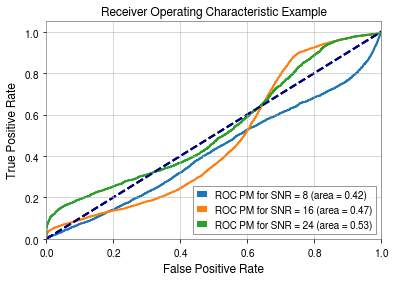

In [24]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/RES_y_PM_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/RES_p_PM_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC PM for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()

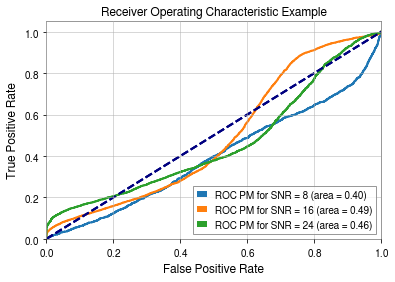

In [25]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/RES_y_SIS_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/RES_p_SIS_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC PM for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()

## NPE

In [18]:
#固定的参数
calculator = Point_mass_lens_model()

LOWER = torch.tensor([0  ,  0. ])
UPPER = torch.tensor([0.2 , 1. ])

#参数归一化与逆运算
def preprocess(theta: torch.Tensor) -> torch.Tensor:
    return 2 * (theta - LOWER) / (UPPER - LOWER) - 1

def postprocess(theta: torch.Tensor) -> torch.Tensor:
    return (theta + 1) / 2 * (UPPER - LOWER) + LOWER


def get_wave_plus_gaosnoise_t_gen_cai_NPE(data):
    nnnyyu=2**5
    samples_all=torch.zeros((data.shape[0],2,nnnyyu))
    for i in range(data.shape[0]):
        estimator_NPE.eval()
        with torch.no_grad():
            samples = estimator_NPE.flow(data[i].reshape(1,4,40960).cuda()).sample((nnnyyu,)).cpu()
            samples = postprocess(samples)
            
        samples_all[i,0,:]=samples[:,0,0]
        samples_all[i,1,:]=samples[:,0,1]
    return samples_all

In [32]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_data_y_roc_PM_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_label_roc_PM_{SNR}.npy'),dtype=torch.float32)
    
    all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(x).reshape(-1,2,2**5)
    
    y_pre_all=[]
    for i in range(all_x_vail.shape[0]):
        model_NPE.eval()
        with torch.no_grad():
            y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
        y_pre_all.append(float(y_pre))
        
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/NPE_y_PM_{SNR}',y)
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/NPE_p_PM_{SNR}',y_pre_all)
    
    del x,y,all_x_vail,y_pre_all

In [ ]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_data_y_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_label_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    
    all_x_vail=get_wave_plus_gaosnoise_t_gen_cai_NPE(x).reshape(-1,2,2**5)
    
    y_pre_all=[]
    for i in range(all_x_vail.shape[0]):
        model_NPE.eval()
        with torch.no_grad():
            y_pre = torch.sigmoid(model_NPE(all_x_vail[i].cuda()[np.newaxis, :]))
        y_pre_all.append(float(y_pre))
        
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/pre/NPE_y_SIS_{SNR}',y)
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/pre/NPE_p_SIS_{SNR}',y_pre_all)
    
    del x,y,all_x_vail,y_pre_all

In [35]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/NPE_y_PM_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/NPE_p_PM_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC PM for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/suntianyang/work5/ligo/data/ROC/pre/NPE_y_PM_8.npy'

<Figure size 432x288 with 0 Axes>

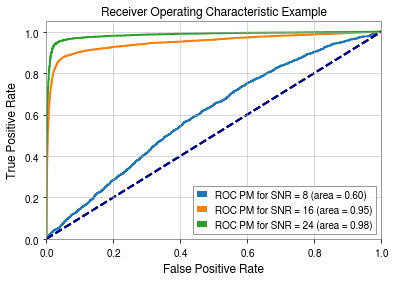

In [27]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/NPE_y_SIS_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/NPE_p_SIS_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC PM for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()

## 直接

In [ ]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_data_y_roc_PM_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_label_roc_PM_{SNR}.npy'),dtype=torch.float32)
    
    y_pre_all=[]
    for i in range(x.shape[0]):
        model_y.eval()
        with torch.no_grad():
            y_pre = torch.sigmoid(model_y(x[i].cuda()[np.newaxis, :]))
        y_pre_all.append(float(y_pre))
        
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/pre/P_y_PM_{SNR}',y)
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/pre/P_p_PM_{SNR}',y_pre_all)
    
    del x,y,y_pre_all

In [ ]:
#I=1.0S时表示两个像相同，这是没有物理意义的，所以不存在
for SNR in [8,16,24]:
    x=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_data_y_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    y=torch.tensor(np.load(f'/home/suntianyang/work5/ligo/data/ROC/test_label_roc_SIS_{SNR}.npy'),dtype=torch.float32)
    
    y_pre_all=[]
    for i in range(x.shape[0]):
        model_y.eval()
        with torch.no_grad():
            y_pre = torch.sigmoid(model_y(x[i].cuda()[np.newaxis, :]))
        y_pre_all.append(float(y_pre))
        
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/pre/P_y_SIS_{SNR}',y)
    np.save(f'/home/suntianyang/work5/ligo/data/ROC/pre/P_p_SIS_{SNR}',y_pre_all)
    
    del x,y,y_pre_all

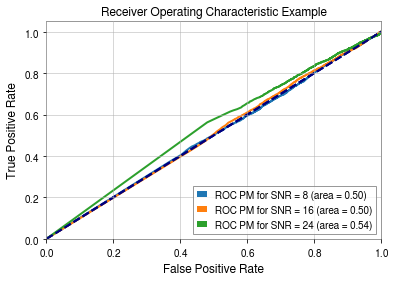

In [28]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/P_y_PM_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/P_p_PM_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC PM for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()

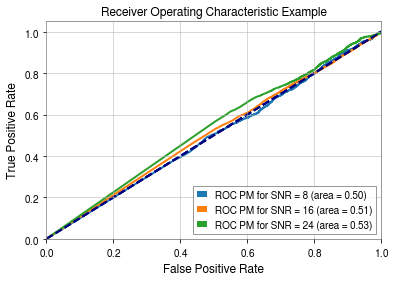

In [29]:
plt.figure()

for SNR in [8,16,24]:

# 假设 y_test 是测试集的真实标签, y_score 是模型对测试集的预测分数
    y_test=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/P_y_SIS_{SNR}.npy')
    y_score=np.load(f'/home/suntianyang/work5/ligo/data/ROC/pre/P_p_SIS_{SNR}.npy')

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    lw = 2
    plt.plot(fpr, tpr,lw=lw, label='ROC PM for SNR = %d (area = %0.2f)' %(SNR,roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Example')
    plt.legend(loc="lower right")
    

    #all_x_vail_data=np.load('./data/test_data_res_y_roc.npy')
    #all_x_vail=np.load('./data/test_data_res_y_roc_can.npy')
    #all_y_vail=np.load('./data/test_label_y_roc_roc.npy')

    #all_x_vail_data=torch.tensor(all_x_vail_data,dtype=torch.float32)
    #all_x_vail=torch.tensor(all_x_vail,dtype=torch.float32)
    
plt.show()